In [1]:
pip install pandas numpy seaborn matplotlib scikit-learn imbalanced-learn xgboost


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the directory containing your dataset
data_path = '/content/drive/MyDrive/csv/Fraud.csv'


Mounted at /content/drive


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Load the dataset
df = pd.read_csv(data_path)

# Display basic information
print("Shape of the data:", df.shape)
print("First few rows of the data:\n", df.head())
print("Checking for null values:", df.isnull().values.any())
df.info()

# Checking the balance of fraud vs legit transactions
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print(f"Legit transactions: {legit} ({legit_percent:.4f}%)")
print(f"Fraud transactions: {fraud} ({fraud_percent:.4f}%)")


# This would take some time to train for a normal GPU.

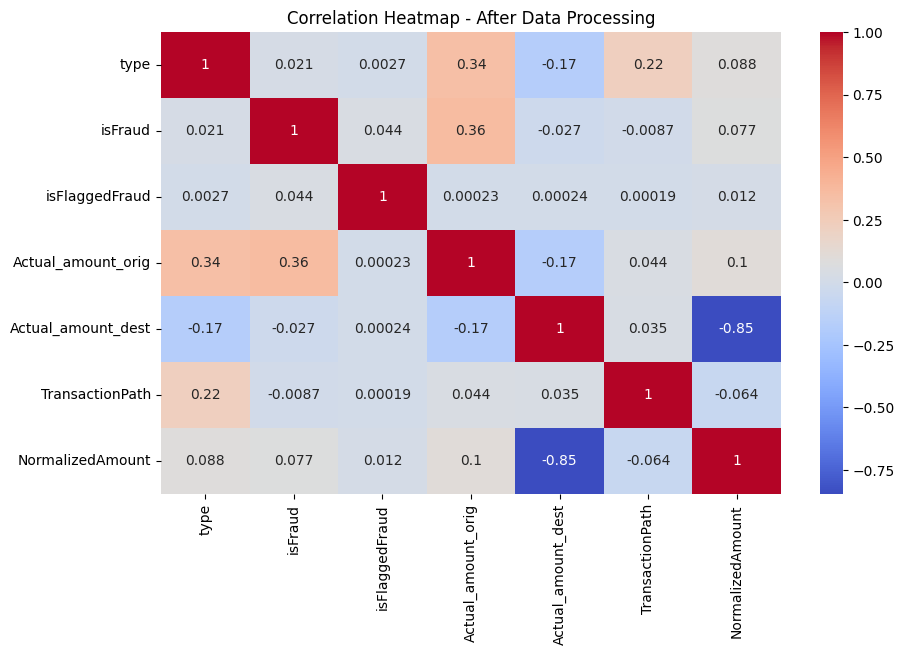

Training set shape: (4453834, 6)
Test set shape: (1908786, 6)


In [11]:
# Create a copy of the dataset
new_df = df.copy()

# Label encoding for categorical features
objList = new_df.select_dtypes(include="object").columns
le = LabelEncoder()
for feat in objList:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

# Feature engineering
new_df['Actual_amount_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'], axis=1)
new_df['Actual_amount_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'], axis=1)
new_df['TransactionPath'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'], axis=1)

# Dropping irrelevant columns
new_df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step', 'nameOrig', 'nameDest'], axis=1, inplace=True)

# Scaling the "amount" column
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace=True, axis=1)

# Correlation heatmap after data processing
plt.figure(figsize=(10,6))
sns.heatmap(new_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap - After Data Processing")
plt.show()

# Splitting the dataset into features (X) and labels (Y)
Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis=1)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


In [6]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_dt = decision_tree.predict(X_test)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_rf = random_forest.predict(X_test)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, Y_train)
Y_pred_xgb = xgb.predict(X_test)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:16:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix - Decision Tree
[[1905605     746]
 [    716    1719]]

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.71      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786



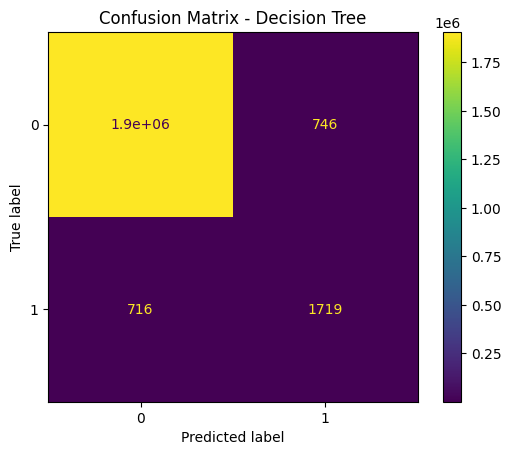


Confusion Matrix - Random Forest
[[1906284      67]
 [    722    1713]]

Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.96      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



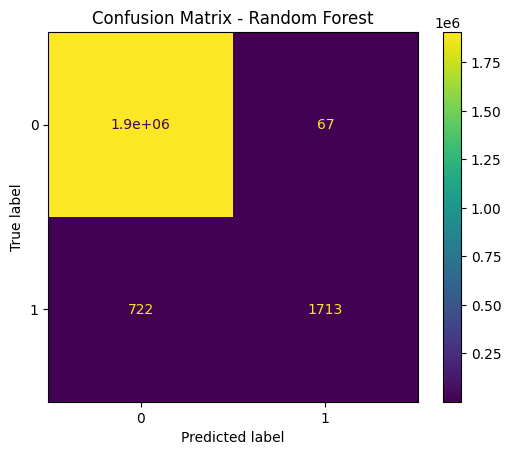


Confusion Matrix - XGBoost
[[1906308      43]
 [    765    1670]]

Classification Report - XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.69      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.84      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786



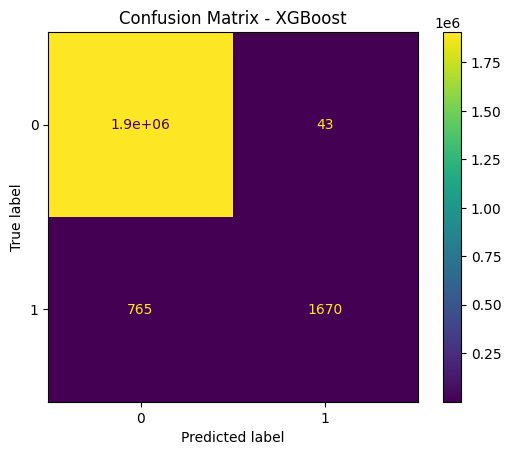

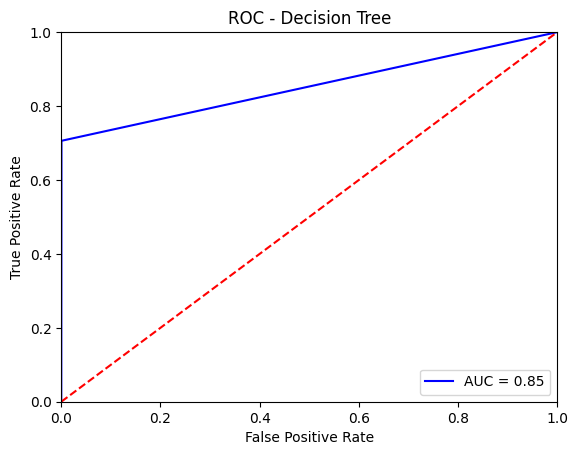

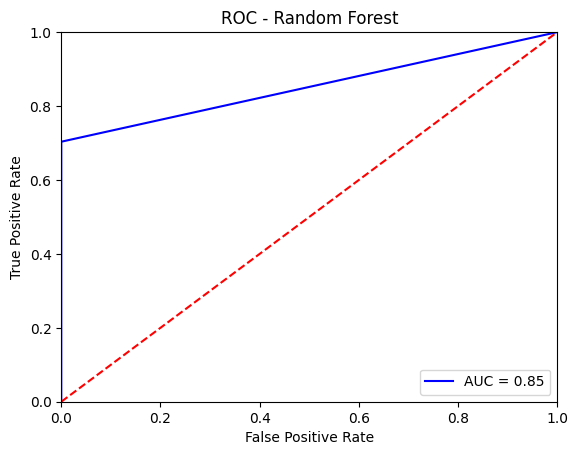

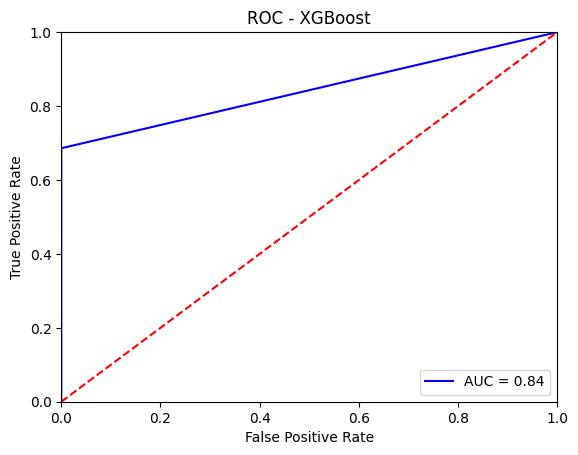

In [7]:
# Function to display metrics
def print_metrics(Y_test, Y_pred, model_name):
    print(f"\nConfusion Matrix - {model_name}")
    print(confusion_matrix(Y_test, Y_pred))

    print(f"\nClassification Report - {model_name}")
    print(classification_report(Y_test, Y_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, Y_pred))
    disp.plot()
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Decision Tree Metrics
print_metrics(Y_test, Y_pred_dt, "Decision Tree")

# Random Forest Metrics
print_metrics(Y_test, Y_pred_rf, "Random Forest")

# XGBoost Metrics
print_metrics(Y_test, Y_pred_xgb, "XGBoost")

# ROC Curve Plotting
def plot_roc_curve(Y_test, Y_pred, model_name):
    fpr, tpr, threshold = roc_curve(Y_test, Y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title(f'ROC - {model_name}')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# ROC Curves for all models
plot_roc_curve(Y_test, Y_pred_dt, "Decision Tree")
plot_roc_curve(Y_test, Y_pred_rf, "Random Forest")
plot_roc_curve(Y_test, Y_pred_xgb, "XGBoost")


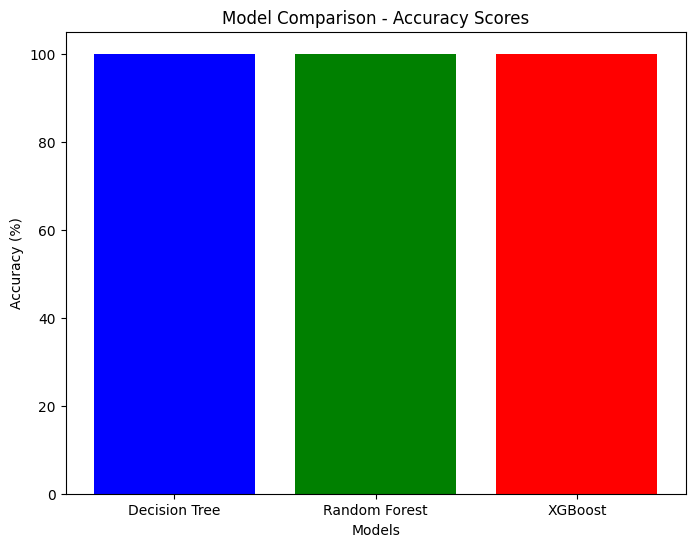

In [8]:
# Compare model accuracy
models = ['Decision Tree', 'Random Forest', 'XGBoost']
scores = [decision_tree.score(X_test, Y_test) * 100,
          random_forest.score(X_test, Y_test) * 100,
          xgb.score(X_test, Y_test) * 100]

plt.figure(figsize=(8, 6))
plt.bar(models, scores, color=['blue', 'green', 'red'])
plt.title("Model Comparison - Accuracy Scores")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.show()


## Conclusion:


In our evaluation of fraud detection models, we found that while Random Forest and Decision Tree had similar accuracy levels, precision is crucial for effective fraud detection. Precision ensures that fraudulent transactions are accurately identified, minimizing the risk of falsely accusing legitimate transactions. Random Forest outperformed Decision Tree with a precision of 0.96 versus 0.70, which makes it more reliable for fraud detection.

Random Forest is particularly well-suited for this task due to its ability to handle highly imbalanced datasets, such as in this case where fraudulent transactions account for only 0.13% of the data compared to 99.87% for legitimate transactions. This method leverages multiple decision trees, which enhances its ability to capture the nuances of fraud detection despite the dataset imbalance.

While models like XGBoost, Bagging, ANN, and Logistic Regression can achieve high accuracy, they may not provide the same level of precision and recall, which are critical for minimizing false positives and false negatives in fraud detection.


## Key Factors Predicting Fraudulent Transactions:

Source of Request: Verify if the request is from a secure and reliable source.
Legitimacy of the Requesting Organization: Check the authenticity of the organization requesting the transaction.
Vendor Transaction History: Evaluate the transaction history of the vendor for any red flags.

1.  **Source of Reques**t: Verify if the request is from a secure and reliable source.
2.  **Legitimacy of the Requesting Organization**: Check the authenticity of the organization requesting the transaction.
3.  **Vendor Transaction History**: Evaluate the transaction history of the vendor for any red flags.






## Preventive Measures for Fraud:

1.  **Use Trusted Applications**: Only use verified and secure applications for transactions.
2. **Ensure Secure Browsing**: Browse through websites that use HTTPS and are known to be secure.
3. **Employ Secure Connections**: Use VPNs and secure internet connections to protect your data.
4. **Keep Security Updated**: Regularly update security software on all devices to defend against new threats.
5. **Be Cautious with Communication**: Avoid responding to unsolicited calls, SMS, or emails that request sensitive information.
6. **Report Suspected Fraud Immediately**: Contact your bank promptly if you suspect any fraudulent activity.

## Evaluating the Effectiveness of Preventive Measures:

1. **Regular E-Statements**: Banks should send electronic statements regularly to keep customers informed.
2. **Account Activity Monitoring**: Customers should frequently review their account activity for any suspicious transactions.
3. **Maintain Payment Logs**: Keep a detailed log of all transactions to quickly identify unauthorized activities.

By adopting these measures, both banks and customers can better manage and mitigate the risks associated with fraud, ensuring that security protocols are effectively protecting against fraudulent activities.